使用先前輸出的bank_handled，和使用optuna調整模型超參數

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/ Bank Marketing")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder ,LabelEncoder ,OrdinalEncoder ,StandardScaler
from imblearn.over_sampling import SMOTE

# Model import
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier ,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier ,XGBRegressor
from sklearn.svm import SVC ,SVR
from sklearn.neighbors import KNeighborsClassifier ,KNeighborsRegressor

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score ,precision_score ,recall_score ,f1_score ,roc_auc_score ,roc_curve ,classification_report ,confusion_matrix
from sklearn.metrics import r2_score ,mean_squared_error, mean_absolute_error ,explained_variance_score

# PipeLine use import
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# sns.set(style="whitegrid")
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# Load Data

In [ ]:
df = pd.read_csv("./bank_handled.csv")

df # 45211 rows × 17 columns

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,contact_cellular,contact_telephone
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,5,8.0,261,1,-1,0,0,0.0,0.0
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,5,8.0,151,1,-1,0,0,0.0,0.0
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,5,8.0,76,1,-1,0,0,0.0,0.0
3,47,1.0,1.0,1.0,0.0,1506,1.0,0.0,5,8.0,92,1,-1,0,0,0.0,0.0
4,33,1.0,2.0,1.0,0.0,1,0.0,0.0,5,8.0,198,1,-1,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9.0,1.0,2.0,0.0,825,0.0,0.0,17,9.0,977,3,-1,0,1,1.0,0.0
45207,71,5.0,0.0,0.0,0.0,1729,0.0,0.0,17,9.0,456,2,-1,0,1,1.0,0.0
45208,72,5.0,1.0,1.0,0.0,5715,0.0,0.0,17,9.0,1127,5,184,3,1,1.0,0.0
45209,57,1.0,1.0,1.0,0.0,668,0.0,0.0,17,9.0,508,4,-1,0,0,0.0,1.0


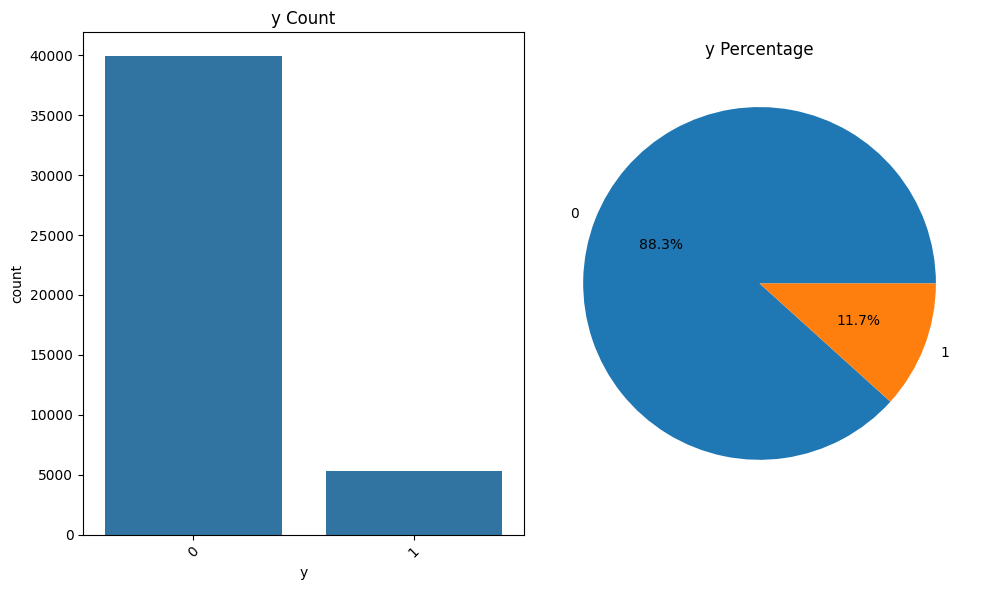

y
0    39922
1     5289
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =df ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = df['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(df['y'].value_counts()) # No:39922(88.3%) ,Yes:5289(11.7%)

# Train Test Split
資料分割，將資料集拆分為訓練集和測試集，針對訓練集的數值特徵做標準化然後做異常值處理

In [ ]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
# print('='*30)
# # 查看全部資料的類別比例
# print(pd.Series(y).value_counts(normalize=True))
# # 查看訓練集標籤的分佈
# print(pd.Series(y_train).value_counts(normalize=True))
# # 查看測試集的標籤分佈
# print(pd.Series(y_test).value_counts(normalize=True))

X_train: (31647, 16)
X_test: (13564, 16)
y_train: (31647,)
y_test: (13564,)


In [ ]:
from collections import Counter

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 27956, 1: 3691})
Testing target statistics: Counter({0: 11966, 1: 1598})


In [ ]:
numeric_cols = X_train.select_dtypes(include=['int','float']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols]) # 在測試集上做相同的轉換

如果在測試集上使用fit_transform，那測試集會使用它自己的平均值和標準差進行轉換，這會導致訓練和測試的資料分布不一致

In [ ]:
def remove_outliers(df, cols, threshold=3):
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

X_train_no_outliers = remove_outliers(pd.DataFrame(X_train, columns=numeric_cols), numeric_cols)
y_train_no_outliers = y_train[X_train_no_outliers.index]

In [ ]:
print(f"Training target statistics: {Counter(y_train_no_outliers)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 23469, 1: 2639})
Testing target statistics: Counter({0: 11966, 1: 1598})


# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_no_outliers, y_train_no_outliers)

In [ ]:
X_resampled # 46938 rows × 16 columns

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,contact_cellular,contact_telephone
0,-4.65e-01,1.46,1.37,1.33,-0.14,-0.46,-1.12,-0.44,0.14,0.16,-0.40,0.39,-0.41,-0.24,-1.36,-0.26
1,1.42e+00,-0.70,-0.28,-0.21,-0.14,-0.39,-1.12,-0.44,0.38,1.16,0.21,0.07,-0.41,-0.24,0.74,-0.26
2,4.76e-01,-1.01,-0.28,-0.21,-0.14,-0.46,0.89,-0.44,-1.30,0.16,-0.67,-0.24,-0.41,-0.24,-1.36,-0.26
3,5.49e-03,-0.08,-1.93,1.33,-0.14,0.69,-1.12,-0.44,-1.78,1.49,0.17,-0.56,0.78,1.81,0.74,-0.26
4,-2.77e-01,-1.01,-0.28,-0.21,-0.14,-0.46,0.89,-0.44,0.50,0.82,-0.65,-0.56,-0.41,-0.24,-1.36,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46933,4.69e-01,-1.32,-0.28,-0.21,-0.14,-0.28,-1.12,-0.44,-1.13,-1.51,0.49,-0.39,-0.41,-0.24,0.74,-0.26
46934,3.70e-01,-0.08,1.37,1.33,-0.14,-0.36,0.89,-0.44,-0.74,-0.09,-0.62,-0.08,-0.41,-0.24,0.74,-0.26
46935,-3.28e-01,-0.08,1.37,1.33,-0.14,-0.20,0.89,-0.44,-1.48,1.00,1.66,0.20,1.33,2.43,0.74,-0.26
46936,-1.64e+00,1.32,1.37,-0.21,-0.14,-0.27,-1.12,-0.44,-0.63,0.04,1.91,-0.41,1.41,0.39,0.74,-0.26


In [ ]:
y_resampled

0        0
1        0
2        0
3        0
4        0
        ..
46933    1
46934    1
46935    1
46936    1
46937    1
Name: y, Length: 46938, dtype: int64

In [ ]:
X_test #　13564 rows × 16 columns

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,contact_cellular,contact_telephone
3776,-8.86e-02,-1.01,-0.28,-0.21,-0.14,-0.26,0.89,-0.44,0.02,0.82,-0.25,-0.56,-0.41,-0.24,-1.36,-0.26
9928,5.70e-01,0.85,1.37,-0.21,-0.14,0.77,-1.12,-0.44,-0.82,0.16,-0.67,-0.24,-0.41,-0.24,-1.36,-0.26
33409,-1.50e+00,1.15,1.37,1.33,-0.14,-0.28,0.89,-0.44,0.50,-1.84,-0.12,-0.56,-0.41,-0.24,0.74,-0.26
31885,9.95e-02,-0.08,-0.28,1.33,-0.14,0.14,-1.12,-0.44,-0.82,-1.84,0.21,-0.56,2.94,0.17,0.74,-0.26
15738,1.42e+00,-0.08,-0.28,1.33,-0.14,-0.38,-1.12,2.29,0.62,-0.17,-0.53,-0.24,-0.41,-0.24,0.74,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,4.76e-01,1.46,1.37,1.33,-0.14,0.48,-1.12,-0.44,-1.30,0.16,-0.81,-0.56,-0.41,-0.24,-1.36,-0.26
380,-2.77e-01,-1.01,-0.28,-0.21,-0.14,-0.20,0.89,-0.44,-1.18,0.82,-0.48,-0.56,-0.41,-0.24,-1.36,-0.26
7713,5.49e-03,-1.32,-0.28,-0.21,-0.14,1.07,-1.12,-0.44,1.70,0.82,0.16,0.07,-0.41,-0.24,-1.36,-0.26
12188,5.49e-03,1.15,-0.28,-0.21,-0.14,-0.02,-1.12,-0.44,0.50,0.16,-0.89,0.39,-0.41,-0.24,-1.36,-0.26


In [ ]:
y_test

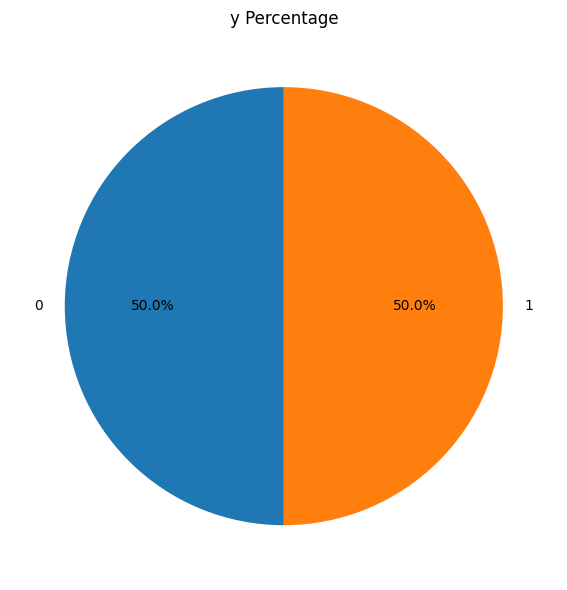

y
0    23469
1    23469
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))

profile_counts = y_resampled.value_counts()
plt.pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(y_resampled.value_counts()) # No:23469(50%) ,Yes:23469(50%)

# Feature Importance

請看更正方式2_Feature Importance的SHAP

In [ ]:
use_columns = ['duration' ,'campaign' ,'month' ,'day' ,'contact_cellular' ,'job' ,'age' ,'pdays']

# 更新訓練集和測試集，只保留這些特徵
X_resampled = X_resampled[use_columns]
X_train_no_outliers = X_train_no_outliers[use_columns]
X_test = X_test[use_columns]

In [ ]:
X_resampled # 46938 rows × 8 columns

,duration,campaign,month,day,contact_cellular,job,age,pdays
0,-0.40,0.39,0.16,0.14,-1.36,1.46,-4.65e-01,-0.41
1,0.21,0.07,1.16,0.38,0.74,-0.70,1.42e+00,-0.41
2,-0.67,-0.24,0.16,-1.30,-1.36,-1.01,4.76e-01,-0.41
3,0.17,-0.56,1.49,-1.78,0.74,-0.08,5.49e-03,0.78
4,-0.65,-0.56,0.82,0.50,-1.36,-1.01,-2.77e-01,-0.41
...,...,...,...,...,...,...,...,...
46933,0.49,-0.39,-1.51,-1.13,0.74,-1.32,4.69e-01,-0.41
46934,-0.62,-0.08,-0.09,-0.74,0.74,-0.08,3.70e-01,-0.41
46935,1.66,0.20,1.00,-1.48,0.74,-0.08,-3.28e-01,1.33
46936,1.91,-0.41,0.04,-0.63,0.74,1.32,-1.64e+00,1.41


In [ ]:
X_train_no_outliers

,duration,campaign,month,day,contact_cellular,job,age,pdays
10747,-0.40,0.39,0.16,0.14,-1.36,1.46,-4.65e-01,-0.41
26054,0.21,0.07,1.16,0.38,0.74,-0.70,1.42e+00,-0.41
9125,-0.67,-0.24,0.16,-1.30,-1.36,-1.01,4.76e-01,-0.41
41659,0.17,-0.56,1.49,-1.78,0.74,-0.08,5.49e-03,0.78
4443,-0.65,-0.56,0.82,0.50,-1.36,-1.01,-2.77e-01,-0.41
...,...,...,...,...,...,...,...,...
6265,-0.66,-0.24,0.82,1.34,-1.36,-1.32,-8.41e-01,-0.41
44732,-0.18,-0.56,1.82,-0.94,0.74,1.15,-1.69e+00,0.51
38158,-0.07,-0.56,0.82,-0.10,0.74,1.46,-6.53e-01,-0.41
860,-0.57,-0.56,0.82,-1.06,-1.36,0.23,-7.47e-01,-0.41


In [ ]:
X_test # 13564 rows × 8 columns

,duration,campaign,month,day,contact_cellular,job,age,pdays
3776,-0.25,-0.56,0.82,0.02,-1.36,-1.01,-8.86e-02,-0.41
9928,-0.67,-0.24,0.16,-0.82,-1.36,0.85,5.70e-01,-0.41
33409,-0.12,-0.56,-1.84,0.50,0.74,1.15,-1.50e+00,-0.41
31885,0.21,-0.56,-1.84,-0.82,0.74,-0.08,9.95e-02,2.94
15738,-0.53,-0.24,-0.17,0.62,0.74,-0.08,1.42e+00,-0.41
...,...,...,...,...,...,...,...,...
9016,-0.81,-0.56,0.16,-1.30,-1.36,1.46,4.76e-01,-0.41
380,-0.48,-0.56,0.82,-1.18,-1.36,-1.01,-2.77e-01,-0.41
7713,0.16,0.07,0.82,1.70,-1.36,-1.32,5.49e-03,-0.41
12188,-0.89,0.39,0.16,0.50,-1.36,1.15,5.49e-03,-0.41


# Model

In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Training Set Evaluation:
Confusion Matrix:
[[22970   499]
 [  893 22576]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     23469
           1       0.98      0.96      0.97     23469

    accuracy                           0.97     46938
   macro avg       0.97      0.97      0.97     46938
weighted avg       0.97      0.97      0.97     46938

AUC:
0.9703438578550428


Testing Set Evaluation:
Confusion Matrix:
[[11376   590]
 [  757   841]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     11966
           1       0.59      0.53      0.56      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.74      0.75     13564
weighted avg       0.90      0.90      0.90     13564

AUC:
0.7384882427620855


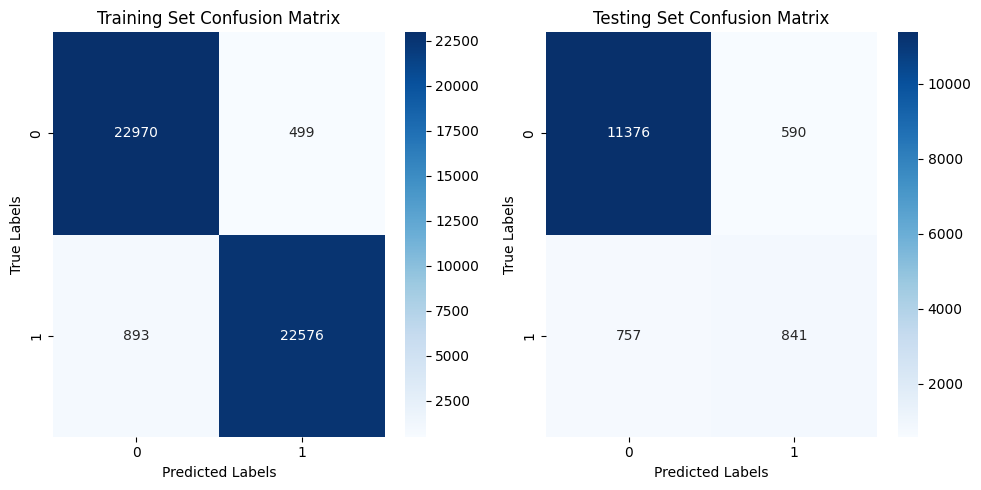

In [ ]:
def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='binary')
    train_recall = recall_score(y_train, y_train_pred, average='binary')
    train_f1 = f1_score(y_train, y_train_pred, average='binary')
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred)
    print("Training Set Evaluation:")
    # print("Accuracy:", train_accuracy)
    # print("Precision:", train_precision)
    # print("Recall:", train_recall)
    # print("F1 Score:", train_f1)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("AUC:")
    print(train_auc)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary')
    test_recall = recall_score(y_test, y_test_pred, average='binary')
    test_f1 = f1_score(y_test, y_test_pred, average='binary')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    print("Testing Set Evaluation:")
    # print("Accuracy:", test_accuracy)
    # print("Precision:", test_precision)
    # print("Recall:", test_recall)
    # print("F1 Score:", test_f1)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)
    print("AUC:")
    print(test_auc)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Training Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Testing Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
evaluate_model_performance(xgb_model, X_resampled, X_test, y_resampled, y_test)

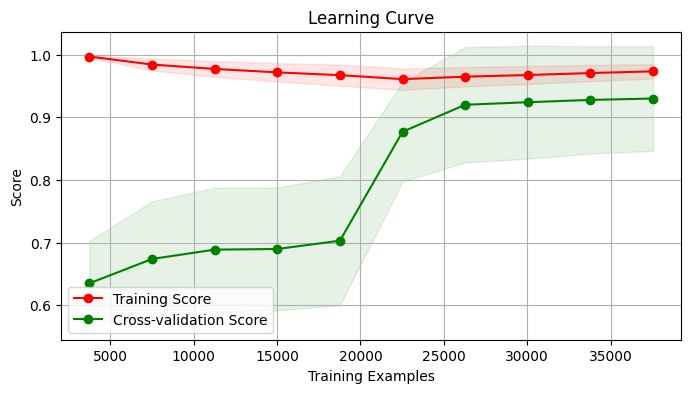

Train Sizes: [ 3755  7510 11265 15020 18775 22530 26285 30040 33795 37550]
Train Scores Mean: [0.99680426 0.9841012  0.97707945 0.97159787 0.96715846 0.96080781
 0.96471752 0.9673968  0.97050451 0.97328362]
Test Scores Mean: [0.6352223  0.67401771 0.68888813 0.68993229 0.70316328 0.87690323
 0.91996018 0.92400808 0.92767239 0.92986674]


In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 4))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()

    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(xgb_model, X_resampled, y_resampled)

# Optuna

In [ ]:
! pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    # dtrain = xgb.DMatrix(X_train_no_outliers, y_train_no_outliers)
    # dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {
        "verbosity": 0,
        'task': 'train',
        "eval_metric": "auc",
        "objective": "binary:logistic",
        "tree_method": "exact",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }
    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 1, 10)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [ ]:
# 最大化評估函數的返回值（例如準確率）時，應選擇 "maximize"
# 最小化評估函數的返回值（例如損失函數）時，應選擇 "minimize"
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-06-16 12:31:33,078] A new study created in memory with name: no-name-e3214510-878b-4fe7-955b-d79a417faf6b
[I 2024-06-16 12:31:33,440] Trial 0 finished with value: 0.8821881450899439 and parameters: {'booster': 'gbtree', 'lambda': 1.504880437799106e-08, 'alpha': 6.161291798633215e-06, 'subsample': 0.7137565257332137, 'colsample_bytree': 0.9321659151264261, 'max_depth': 5, 'min_child_weight': 5, 'eta': 5.9063168140028925e-06, 'gamma': 5.4614084150704885e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8821881450899439.
[I 2024-06-16 12:31:33,591] Trial 1 finished with value: 0.8821881450899439 and parameters: {'booster': 'gbtree', 'lambda': 0.40677398687678323, 'alpha': 0.0010963250898952867, 'subsample': 0.4175076524571803, 'colsample_bytree': 0.7863159034947167, 'max_depth': 1, 'min_child_weight': 6, 'eta': 0.005477251519653177, 'gamma': 1.4266565654446575e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8821881450899439.
[I 2024-06-16 12:31:33,837

Best trial:
  Value: 0.899955765260985
  Params: 
    booster: gbtree
    lambda: 5.180791907061678e-07
    alpha: 3.070223843490789e-06
    subsample: 0.5804917926442956
    colsample_bytree: 0.9269804779037699
    max_depth: 7
    min_child_weight: 3
    eta: 0.2859552267313297
    gamma: 0.01990678643743319
    grow_policy: lossguide


In [ ]:
trial.params

{'booster': 'gbtree',
 'lambda': 5.180791907061678e-07,
 'alpha': 3.070223843490789e-06,
 'subsample': 0.5804917926442956,
 'colsample_bytree': 0.9269804779037699,
 'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.2859552267313297,
 'gamma': 0.01990678643743319,
 'grow_policy': 'lossguide'}

In [ ]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [ ]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

Training Set Evaluation:
Confusion Matrix:
[[21099  2370]
 [ 1281 22188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     23469
           1       0.90      0.95      0.92     23469

    accuracy                           0.92     46938
   macro avg       0.92      0.92      0.92     46938
weighted avg       0.92      0.92      0.92     46938

AUC: 0.9780082438122446
Testing Set Evaluation:
Confusion Matrix:
[[10525  1441]
 [  406  1192]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     11966
           1       0.45      0.75      0.56      1598

    accuracy                           0.86     13564
   macro avg       0.71      0.81      0.74     13564
weighted avg       0.90      0.86      0.88     13564

AUC: 0.9026372071725123


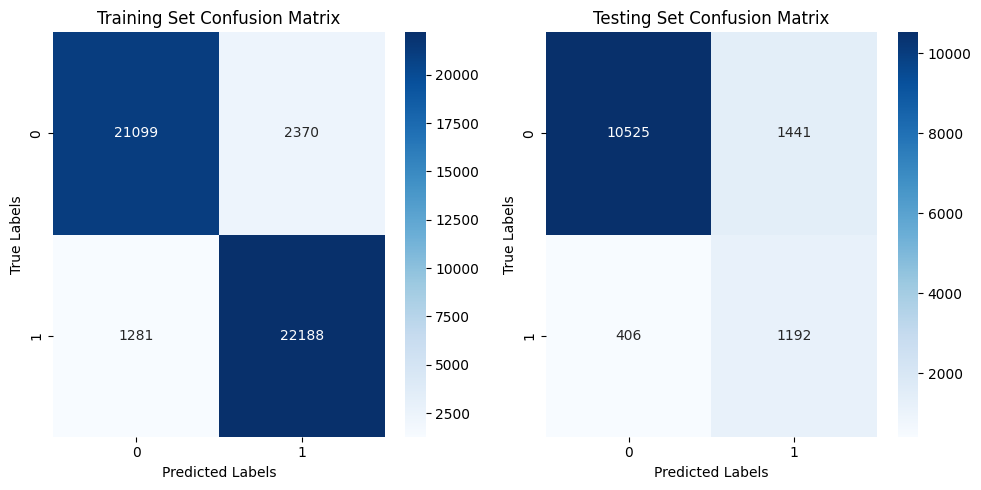

In [ ]:
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

best_model = xgb.train(study.best_params, dtrain)

# 訓練集評估
y_train_pred = best_model.predict(dtrain)
train_pred_labels = np.rint(y_train_pred)
train_conf_matrix = confusion_matrix(y_resampled, train_pred_labels)
train_classification_report = classification_report(y_resampled, train_pred_labels)
train_auc = roc_auc_score(y_resampled, y_train_pred)
print("Training Set Evaluation:")
print("Confusion Matrix:")
print(train_conf_matrix)
print("Classification Report:")
print(train_classification_report)
print("AUC:", train_auc)

# 測試集評估
y_test_pred = best_model.predict(dtest)
test_pred_labels = np.rint(y_test_pred)
test_conf_matrix = confusion_matrix(y_test, test_pred_labels)
test_classification_report = classification_report(y_test, test_pred_labels)
test_auc = roc_auc_score(y_test, y_test_pred)
print("Testing Set Evaluation:")
print("Confusion Matrix:")
print(test_conf_matrix)
print("Classification Report:")
print(test_classification_report)
print("AUC:", test_auc)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Testing Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

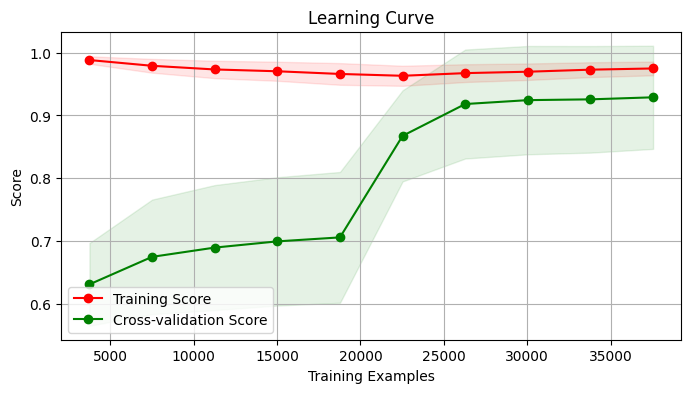

Train Sizes: [ 3755  7510 11265 15020 18775 22530 26285 30040 33795 37550]
Train Scores Mean: [0.98806924 0.97893475 0.97310253 0.97022636 0.96596538 0.96304483
 0.96727411 0.96950732 0.97277112 0.97469507]
Test Scores Mean: [0.63145132 0.67518977 0.68991073 0.69979663 0.7061248  0.86752905
 0.91814918 0.92432756 0.92558451 0.92882278]


In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 4))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()

    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)

# Train the model using the best parameters
best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_resampled, y_resampled)

# Plot learning curve
plot_learning_curve(best_model, X_resampled, y_resampled)

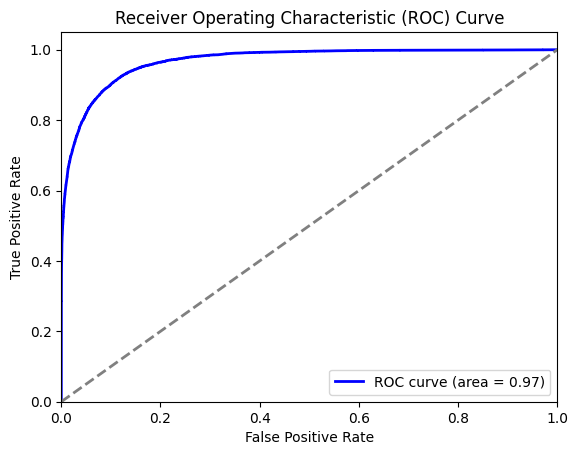

In [ ]:
X_combined = np.vstack((X_resampled, X_test))
y_combined = np.hstack((y_resampled, y_test))

dcombined = xgb.DMatrix(X_combined, label=y_combined, feature_names=dtrain.feature_names)

y_combined_pred = best_model.predict(dcombined)
combined_auc = roc_auc_score(y_combined, y_combined_pred)
fpr, tpr, _ = roc_curve(y_combined, y_combined_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % combined_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 使用 XGBClassifier 和使用 xgb.train 兩者的差異

In [ ]:
# 使用 XGBClassifier
xgb_clf = xgb.XGBClassifier(**trial.params)
xgb_clf.fit(X_resampled, y_resampled)
y_pred_clf = xgb_clf.predict(X_test)

# 使用 xgb.train
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)
best_model = xgb.train(study.best_params, dtrain)
y_pred_train = best_model.predict(dtest)
y_pred_train = (y_pred_train > 0.5).astype(int)  # 根據閾值進行分類

# 混淆矩陣
from sklearn.metrics import confusion_matrix

cm_clf = confusion_matrix(y_test, y_pred_clf)
cm_train = confusion_matrix(y_test, y_pred_train)

print("Confusion Matrix for XGBClassifier:")
print(cm_clf)

print("Confusion Matrix for xgb.train:")
print(cm_train)

Confusion Matrix for XGBClassifier:
[[11388   578]
 [  783   815]]
Confusion Matrix for xgb.train:
[[10525  1441]
 [  406  1192]]


In [ ]:
trial.params

{'booster': 'gbtree',
 'lambda': 5.180791907061678e-07,
 'alpha': 3.070223843490789e-06,
 'subsample': 0.5804917926442956,
 'colsample_bytree': 0.9269804779037699,
 'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.2859552267313297,
 'gamma': 0.01990678643743319,
 'grow_policy': 'lossguide'}

In [ ]:
study.best_params

{'booster': 'gbtree',
 'lambda': 5.180791907061678e-07,
 'alpha': 3.070223843490789e-06,
 'subsample': 0.5804917926442956,
 'colsample_bytree': 0.9269804779037699,
 'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.2859552267313297,
 'gamma': 0.01990678643743319,
 'grow_policy': 'lossguide'}